In [64]:
# imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import glob 
from sklearn.utils import shuffle 
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import cv2 

# Introduction 

File naming format: NFI-XXXYYZZZ  
- XXX - ID number of the person who has done the signature.  
- YY - Image sample number.  
- ZZZ - ID number of person's signature that is in the photo. 

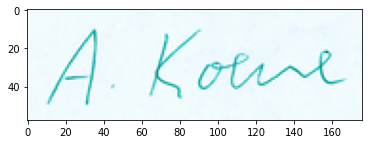

In [36]:
# check out one of the genuine sample signatures 
genuine_tmp = plt.imread('data\\sample_Signature\\sample_Signature\\genuine\\NFI-01401014.png')
plt.imshow(genuine_tmp)

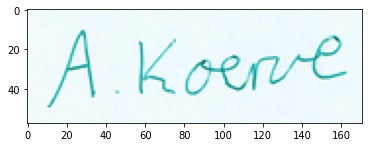

In [37]:
# check out one of the forged sample signatures 
forged_tmp = plt.imread('data\\sample_Signature\\sample_Signature\\forged\\NFI-00101014.png')
plt.imshow(forged_tmp)

# Read in and Format Data 

In [38]:
genuine_files = [
    glob.glob('data/Dataset_Signature_Final/Dataset/dataset1/real/*.*'),
    glob.glob('data/Dataset_Signature_Final/Dataset/dataset2/real/*.*'),
    glob.glob('data/Dataset_Signature_Final/Dataset/dataset3/real/*.*'),
    glob.glob('data/Dataset_Signature_Final/Dataset/dataset4/real/*.*')
]

forged_files = [
    glob.glob('data/Dataset_Signature_Final/Dataset/dataset1/forge/*.*'), 
    glob.glob('data/Dataset_Signature_Final/Dataset/dataset2/forge/*.*'),
    glob.glob('data/Dataset_Signature_Final/Dataset/dataset3/forge/*.*'),
    glob.glob('data/Dataset_Signature_Final/Dataset/dataset4/forge/*.*')
]

In [39]:
train_data = []
train_labels = []
test_data = []
test_labels = []

# genuine signatures 
for data in range(len(genuine_files)):
    for img in genuine_files[data]:
        image = cv2.imread(img) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        if data == 3:
            test_data.append(image)
            test_labels.append(0)   # label 0 for genuine
        else:
            train_data.append(image) 
            train_labels.append(0)   # label 0 for genuine 

# forged signatures
for data in range(len(forged_files)):
    for img in forged_files[data]:
        image = cv2.imread(img) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        if data == 3:
            test_data.append(image)
            test_labels.append(1)   # label 1 for forged 
        else:
            train_data.append(image) 
            train_labels.append(1)  # label 1 for forged 

In [40]:
train_data = np.array(train_data) / 255.0 
train_labels = np.array(train_labels)

test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)

In [41]:
train_data.shape

(540, 224, 224, 3)

In [42]:
train_labels.shape

(540,)

In [43]:
test_data.shape

(180, 224, 224, 3)

In [44]:
test_labels.shape

(180,)

In [45]:
train_data, train_labels = shuffle(train_data, train_labels, random_state = 42)
test_data, test_labels = shuffle(test_data, test_labels, random_state = 42)

# Modeling

In [55]:
EPOCHS = 20
BATCH_SIZE = 1

## Model 1  
Building a model from scratch using Keras.  Model 1 uses the raw dataset as is. 

In [59]:
model1 = Sequential()
lr1 = 0.001

model1_tensor_board = TensorBoard(log_dir = './logs/model1')
model1_early_stop = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, restore_best_weights = True)
model1_reduce_lr_plat = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.0001, patience = 5, verbose = 1)
model1_callbacks = [model1_reduce_lr_plat, model1_tensor_board]

model1.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))
model1.add(MaxPool2D(3, 3))
model1.add(Conv2D(64, (3, 3), activation = 'relu'))
model1.add(MaxPool2D(2, 2))
model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(rate = 0.3))
model1.add(Dense(1, activation = 'sigmoid'))

model1.compile(optimizer = Adam(learning_rate = lr1), loss = 'binary_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 82944)             0         
                                                                 
 dense_16 (Dense)            (None, 128)              

In [60]:
history = model1.fit(
    train_data, 
    train_labels, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    callbacks = model1_callbacks, 
    validation_split = 0.1
)

Epoch 1/20
486/486 [==============================] - 22s 44ms/step - loss: 0.7833 - accuracy: 0.4609 - val_loss: 0.6924 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 2/20
486/486 [==============================] - 20s 42ms/step - loss: 0.7409 - accuracy: 0.4959 - val_loss: 0.6946 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/20
486/486 [==============================] - 20s 42ms/step - loss: 0.7437 - accuracy: 0.5021 - val_loss: 0.7585 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 4/20
486/486 [==============================] - 20s 42ms/step - loss: 0.6786 - accuracy: 0.5329 - val_loss: 0.6885 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 5/20
486/486 [==============================] - 20s 42ms/step - loss: 0.6230 - accuracy: 0.5082 - val_loss: 0.7323 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 6/20
486/486 [==============================] - 21s 43ms/step - loss: 0.5762 - accuracy: 0.6008 - val_loss: 0.9959 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 7/20
486/486 [==============================] - 21s 

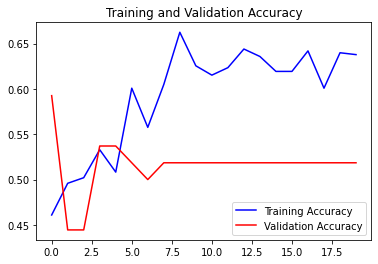

In [61]:
model1_acc = history.history['accuracy']
model1_val_acc = history.history['val_accuracy']
model1_loss = history.history['loss']
model1_val_loss = history.history['val_loss']
model1_epochs = range(len(model1_acc))

plt.plot(model1_epochs, model1_acc, 'b', label = 'Training Accuracy') 
plt.plot(model1_epochs, model1_val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy') 
plt.legend()
plt.show()

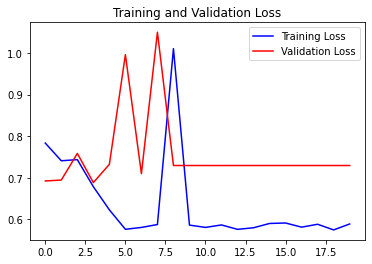

In [62]:
plt.plot(model1_epochs, model1_loss, 'b', label = 'Training Loss')
plt.plot(model1_epochs, model1_val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [63]:
model1_preds = model1.predict(test_data)
model1_preds 

6/6 [==============================] - 0s 56ms/step


array([[3.0970803e-04],
       [1.1647013e-04],
       [2.4776019e-02],
       [6.8221396e-01],
       [1.7063113e-01],
       [3.0401085e-05],
       [5.5492753e-01],
       [7.3072857e-01],
       [7.3201351e-02],
       [9.9258310e-01],
       [4.0106320e-01],
       [1.5566160e-01],
       [8.7483031e-01],
       [4.2310092e-01],
       [2.2762014e-01],
       [4.6253022e-05],
       [7.8077823e-02],
       [3.4157891e-02],
       [8.8475084e-01],
       [9.5174444e-01],
       [9.6162742e-01],
       [9.9998242e-01],
       [6.4840204e-01],
       [3.3982020e-04],
       [2.8362588e-03],
       [7.5899374e-01],
       [4.0710044e-01],
       [1.3707753e-04],
       [1.6181457e-01],
       [3.2645869e-01],
       [9.5609355e-01],
       [5.7906795e-01],
       [9.1398519e-01],
       [4.9419460e-01],
       [4.0531773e-02],
       [5.0775899e-04],
       [9.7744620e-01],
       [9.7621179e-01],
       [1.3426565e-01],
       [5.4863385e-06],
       [9.9930769e-01],
       [7.746505

In [74]:
model1_pred_acc = accuracy_score(np.round(model1_preds), test_labels)
print(f'Model 1 Predictions accuracy: {round(model1_pred_acc, 4) * 100}%')

Model 1 Predictions accuracy: 70.56%


In [76]:
print(classification_report(test_labels, np.round(model1_preds)))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        90
           1       0.75      0.61      0.67        90

    accuracy                           0.71       180
   macro avg       0.71      0.71      0.70       180
weighted avg       0.71      0.71      0.70       180



## Model 2  
